#### Import Libraries

In [1]:
import pandas as pd
import urllib
import json
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np


#### Create a Database connection

In [2]:
conn = sqlite3.connect('ml_project.db')

#### API to get Poverty data for every county

In [3]:
poverty_url = 'https://api.census.gov/data/timeseries/poverty/saipe?get=NAME,SAEPOVRTALL_PT,SAEPOVALL_PT&for=county:*&time=2016'

#### API to get insurance data for every county

In [4]:
health_url = 'https://api.census.gov/data/timeseries/healthins/sahie?get=NIC_PT,NAME,NUI_PT&for=county:*&time=2016'

In [11]:
poverty_txt = urllib.request.urlopen(poverty_url).read() 
poverty_txt

b'[["NAME","SAEPOVRTALL_PT","SAEPOVALL_PT","time","state","county"],\n["Autauga County","13.5","7444","2016","01","001"],\n["Baldwin County","11.7","24005","2016","01","003"],\n["Barbour County","29.9","6787","2016","01","005"],\n["Bibb County","20.1","4099","2016","01","007"],\n["Blount County","14.1","8033","2016","01","009"],\n["Bullock County","32.6","2841","2016","01","011"],\n["Butler County","24.8","4880","2016","01","013"],\n["Calhoun County","17.1","19057","2016","01","015"],\n["Chambers County","19.9","6656","2016","01","017"],\n["Cherokee County","16.8","4273","2016","01","019"],\n["Chilton County","18.3","7960","2016","01","021"],\n["Choctaw County","22.7","2910","2016","01","023"],\n["Clarke County","29","6977","2016","01","025"],\n["Clay County","18.9","2495","2016","01","027"],\n["Cleburne County","17.2","2527","2016","01","029"],\n["Coffee County","14.4","7271","2016","01","031"],\n["Colbert County","16.7","8982","2016","01","033"],\n["Conecuh County","28.1","3464","201

In [12]:
poverty_list = json.loads(poverty_txt)
poverty_list

[['NAME', 'SAEPOVRTALL_PT', 'SAEPOVALL_PT', 'time', 'state', 'county'],
 ['Autauga County', '13.5', '7444', '2016', '01', '001'],
 ['Baldwin County', '11.7', '24005', '2016', '01', '003'],
 ['Barbour County', '29.9', '6787', '2016', '01', '005'],
 ['Bibb County', '20.1', '4099', '2016', '01', '007'],
 ['Blount County', '14.1', '8033', '2016', '01', '009'],
 ['Bullock County', '32.6', '2841', '2016', '01', '011'],
 ['Butler County', '24.8', '4880', '2016', '01', '013'],
 ['Calhoun County', '17.1', '19057', '2016', '01', '015'],
 ['Chambers County', '19.9', '6656', '2016', '01', '017'],
 ['Cherokee County', '16.8', '4273', '2016', '01', '019'],
 ['Chilton County', '18.3', '7960', '2016', '01', '021'],
 ['Choctaw County', '22.7', '2910', '2016', '01', '023'],
 ['Clarke County', '29', '6977', '2016', '01', '025'],
 ['Clay County', '18.9', '2495', '2016', '01', '027'],
 ['Cleburne County', '17.2', '2527', '2016', '01', '029'],
 ['Coffee County', '14.4', '7271', '2016', '01', '031'],
 ['Colb

In [13]:
poverty_df = pd.DataFrame(poverty_list[1:], columns=poverty_list[0]) 
poverty_df.head()

,NAME,SAEPOVRTALL_PT,SAEPOVALL_PT,time,state,county
0,Autauga County,13.5,7444,2016,01,001
1,Baldwin County,11.7,24005,2016,01,003
2,Barbour County,29.9,6787,2016,01,005
3,Bibb County,20.1,4099,2016,01,007
4,Blount County,14.1,8033,2016,01,009


In [14]:
poverty_df.to_sql('poverty', conn)

In [15]:
health_txt = urllib.request.urlopen(health_url).read() 


In [16]:
health_list = json.loads(health_txt) 

In [17]:
health_df = pd.DataFrame(health_list[1:], columns=health_list[0]) 

In [18]:
health_df.to_sql('health', conn)

In [19]:
conn.close()

In [21]:
fulldata = pd.merge(health_df, poverty_df.iloc[:,[1,2,4,5]], on=['state', 'county'])
fulldata.head()

,NIC_PT,NAME,NUI_PT,time,state,county,SAEPOVRTALL_PT,SAEPOVALL_PT
0,43075,"Autauga County, AL",4002,2016,01,001,13.5,7444
1,148007,"Baldwin County, AL",17733,2016,01,003,11.7,24005
2,15745,"Barbour County, AL",2252,2016,01,005,29.9,6787
3,15358,"Bibb County, AL",1646,2016,01,007,20.1,4099
4,41382,"Blount County, AL",5704,2016,01,009,14.1,8033


In [33]:
fulldata = fulldata[(fulldata == "N/A").sum(axis=1) == 0].copy()
fulldata.to_csv('full_data.csv')

In [25]:
mydata = fulldata.iloc[:, [0,2,6]].astype(float)
mydata.head()

,NIC_PT,NUI_PT,SAEPOVRTALL_PT
0,43075.0,4002.0,13.5
1,148007.0,17733.0,11.7
2,15745.0,2252.0,29.9
3,15358.0,1646.0,20.1
4,41382.0,5704.0,14.1


In [26]:
mydata['uninsured_prctn'] = mydata['NUI_PT']/(mydata['NUI_PT'] + mydata['NIC_PT'])*100
mydata.head()

,NIC_PT,NUI_PT,SAEPOVRTALL_PT,uninsured_prctn
0,43075.0,4002.0,13.5,8.500967
1,148007.0,17733.0,11.7,10.699288
2,15745.0,2252.0,29.9,12.513197
3,15358.0,1646.0,20.1,9.680075
4,41382.0,5704.0,14.1,12.114004


 #### features: column 3 which is percent of poverty (numpy array)


In [34]:
X = mydata.iloc[:,[2]].values
X

array([[13.5],
       [11.7],
       [29.9],
       ...,
       [10.6],
       [13.1],
       [10.7]])

#### target: column 4 which is percent of uninsured (numpy array)

In [36]:
y = mydata.iloc[:,3].values
y

array([ 8.5009665 , 10.69928804, 12.51319664, ..., 12.56897609,
       16.70822943, 14.35218325])

#### Correlation coefficient between %poverty and %uninsured

In [37]:
mydata.iloc[:,[2,3]].corr()

,SAEPOVRTALL_PT,uninsured_prctn
SAEPOVRTALL_PT,1.00000,0.37279
uninsured_prctn,0.37279,1.00000


## Finding : There is a 37% corelation between poverty and unisured people

#### Add log transformation to the dataframe and find the correlation

In [39]:
mydata['Log_uninsured_prctn'] = np.log(mydata['uninsured_prctn'])
mydata['Log_SAEPOVRTALL_PT'] = np.log(mydata['SAEPOVRTALL_PT'])
mydata.iloc[:,[4,5]].corr()

,Log_uninsured_prctn,Log_SAEPOVRTALL_PT
Log_uninsured_prctn,1.000000,0.440998
Log_SAEPOVRTALL_PT,0.440998,1.000000


## Finding : By changing the numbers to their logarithmic values the corelation is ~44%

#### save this data to a dataframe

In [40]:
mydata.to_csv('project_data.csv')

#### Split data into two groups of test and train

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### create a linear regression object

In [42]:
lr = LinearRegression()

#### train the model

In [43]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### accuracy of model on test data 

In [44]:
lr.score(X_test, y_test)

0.14402549621819527

#### predicted values using Linear Regression Model

In [46]:
y_pred = lr.predict(X)
y_pred

array([10.53725177, 10.00173567, 15.41639848, ...,  9.67447583,
       10.4182482 ,  9.70422673])

#### Scatter plot betweenn uninsured_prctn and poverty

Text(0,0.5,'Percentage of Uninsured')

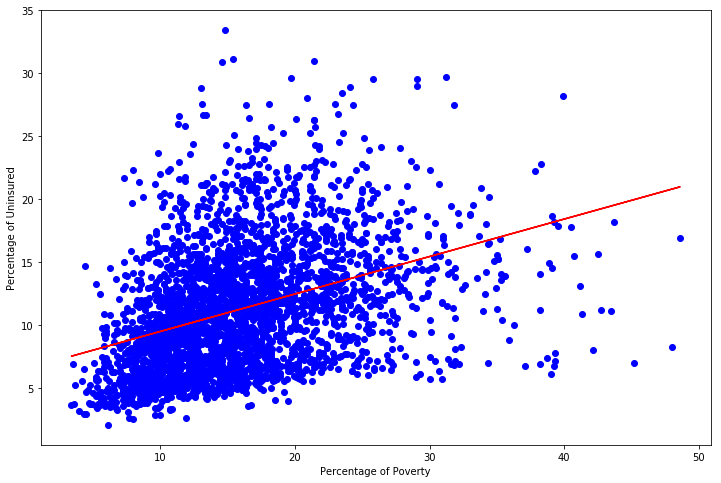

In [49]:
plt.figure(figsize=(12,8))
plt.plot(X, y, 'bo')
plt.plot(X,y_pred, 'r-')
plt.xlabel('Percentage of Poverty')
plt.ylabel('Percentage of Uninsured')

#### Plot the histogram of poverty and uninsured, notice the long tail

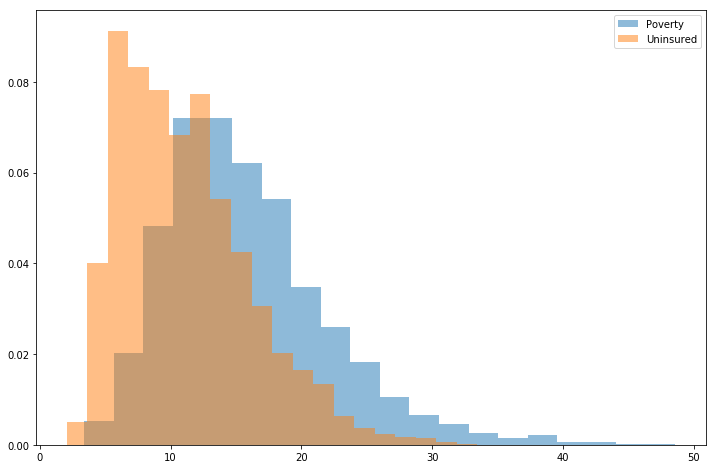

In [50]:
plt.figure(figsize=(12,8))
plt.hist(X, bins=20, density=True, label='Poverty', alpha = 0.5)
plt.hist(y, bins=20, density=True, label='Uninsured', alpha = 0.5)
plt.legend()

#### Plot the Bubble of LOG of poverty and LOG of uninsured

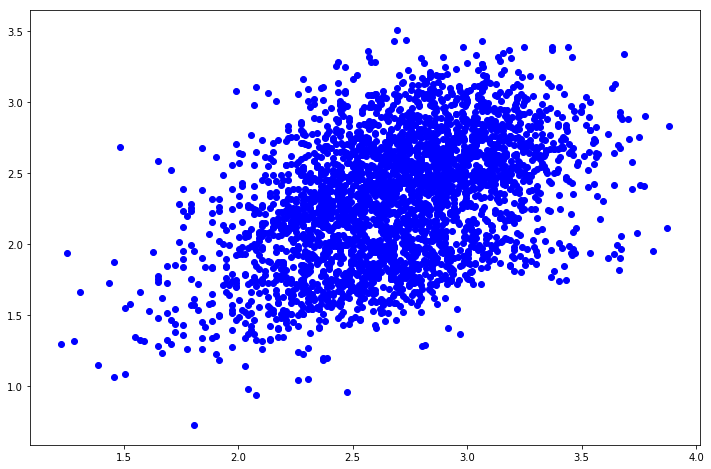

In [52]:
X_log = np.log(X)
y_log = np.log(y)
plt.figure(figsize=(12,8))
plt.plot(X_log, y_log, 'bo')

#### Plot the histogram of LOG poverty and LOG uninsured. The figure is closer to a Bell curve

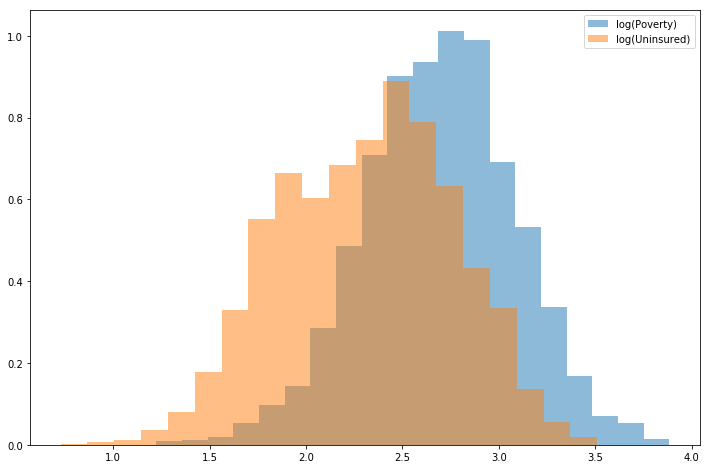

In [53]:
plt.figure(figsize=(12,8))
plt.hist(X_log, bins=20, density=True, label='log(Poverty)', alpha = 0.5)
plt.hist(y_log, bins=20, density=True, label='log(Uninsured)', alpha = 0.5)
plt.legend()

### Split LOG data into two groups of test and train

In [54]:
X_log_train, X_log_test, y_log_train, y_log_test = \
        train_test_split(X_log, y_log, test_size=0.25, random_state=42)

#### create a linear regression object

In [55]:
lr = LinearRegression()

#### Train the model

In [56]:
lr.fit(X_log_train, y_log_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### accuracy of model on test data 

In [57]:
lr.score(X_log_test, y_log_test)

0.20088738095511427

#### predicted values using Linear Regression Model

In [59]:
y_log_pred = lr.predict(X_log)

#### Scatter plot betweenn uninsured_prctn and poverty

Text(0,0.5,'Percentage of Uninsured')

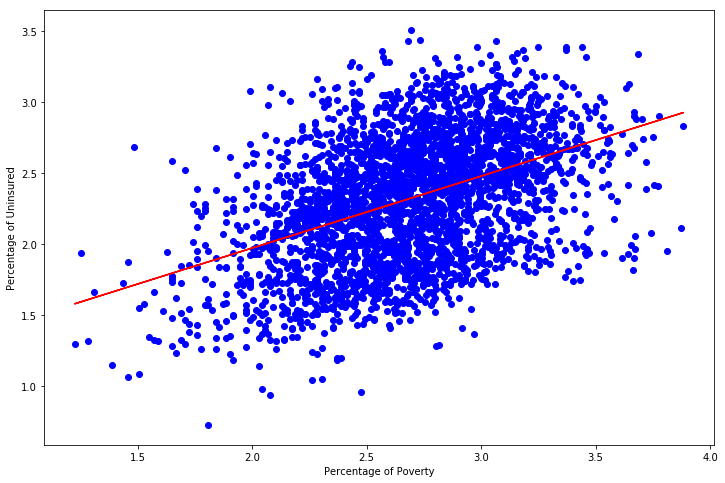

In [60]:
plt.figure(figsize=(12,8))
plt.plot(X_log, y_log, 'bo')
plt.plot(X_log,y_log_pred, 'r-')
plt.xlabel('Percentage of Poverty')
plt.ylabel('Percentage of Uninsured') 